# Todo

## MAGIC dataset
* kNN
* LR(?)
* NN using tensorflow
* XGBoost
* PCA
* Rerun methods
* Write report comparing methods and discussing importance of PCA for ten features (19020 datapoints) where some have correlation

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as sklne
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import tensorflow as tf
import seaborn as sns
import scikitplot as sklplt
import sklearn.metrics as sklme
import tensorflow_addons as tfa
import xgboost as xgb

fonts = {
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

plt.rcParams.update(fonts)

np.random.seed(123)

<IPython.core.display.Javascript object>

In [2]:
# Black for Jupyter Notebook!
%load_ext nb_black

<IPython.core.display.Javascript object>

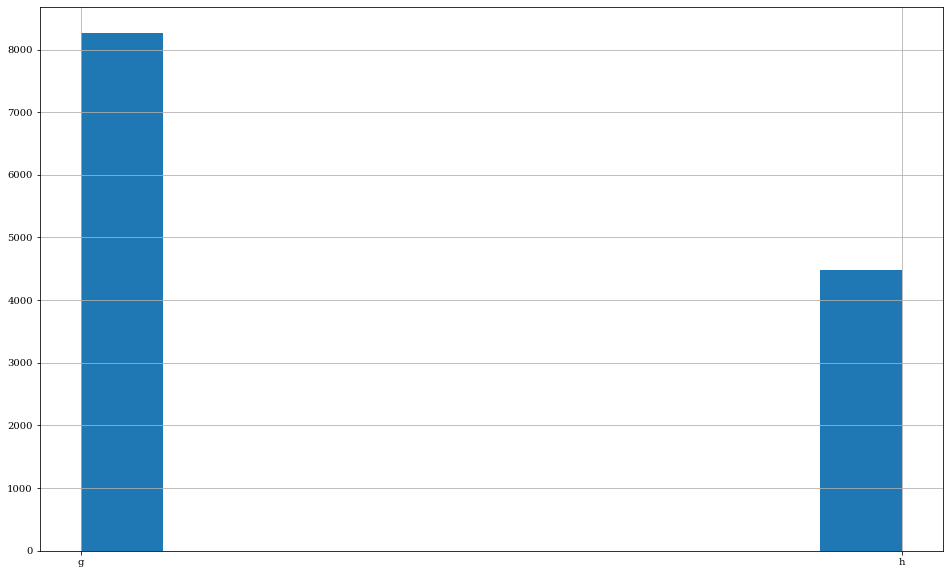

<IPython.core.display.Javascript object>

In [3]:
# Reading data
df = pd.read_csv("telescope_data.csv")
# Dropping useless column
df.drop("Unnamed: 0", axis=1, inplace=True)
# Setting feature matrix X and outcome y
X = df.drop("class", axis=1)
y = df["class"]

# Splitting
X_train, X_test, y_train, y_test = sklms.train_test_split(
    X, y, stratify=y, test_size=0.33
)

# Scaling feature matrix (All features are scalar).
scaler = sklpre.StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns
)
X_test = pd.DataFrame(scaler.transform(X_test.to_numpy()), columns=X_test.columns)

# One-hot encoding outcomes, keeping them as dataframes
encoder = sklpre.OneHotEncoder(categories="auto", sparse=False)
# Plotting histogram of outcomes
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
y_train.hist(ax=ax, density=False)

y_train = pd.DataFrame(
    encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
y_test = pd.DataFrame(
    encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)

plt.show()
# Deleting non-used objects to avoid bugs later and save memory
del X
del y
del df

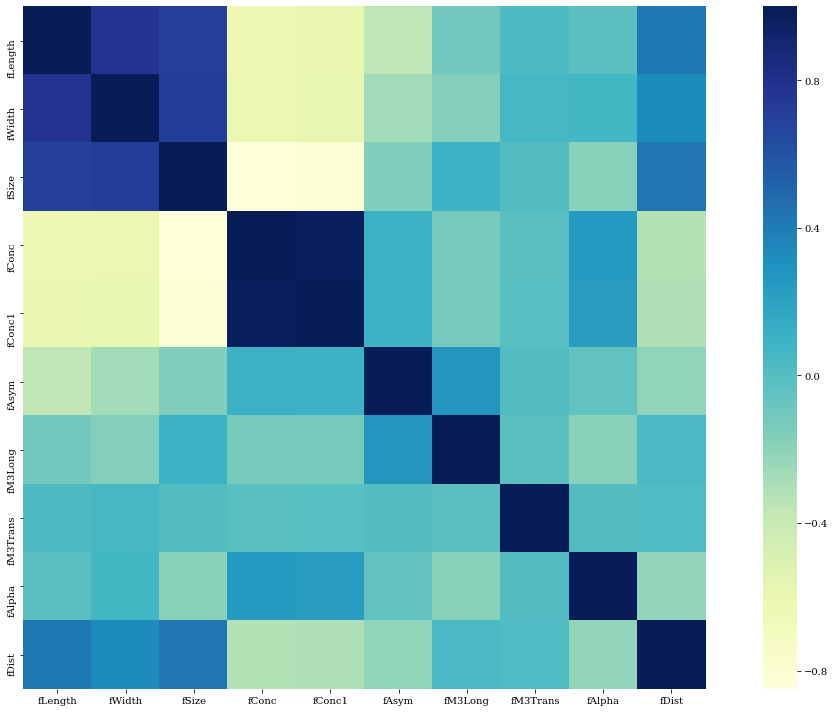

<IPython.core.display.Javascript object>

In [4]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(X_train.corr(), cmap="YlGnBu", ax=ax, square=True)
ax.set_ylim([10, 0])
ax.set_xlim([0, 10])
fig.tight_layout()
plt.show()

# kNN

In [5]:
knn_base = sklne.KNeighborsClassifier()

hyperparams_knn = {"n_neighbors": np.arange(1, 50)}
# As we saw in the earlier plot, we have an imbalanced dataset. Therefore we use the F1 score instead of accuracy
grid_search_knn = sklms.GridSearchCV(
    knn_base,
    hyperparams_knn,
    scoring="f1_weighted",
    cv=5,
    iid=False,
    n_jobs=-1,
    verbose=0,
).fit(X_train, y_train)

<IPython.core.display.Javascript object>

k-NN:
Train weighted f1 score: 0.88
Test weighted f1 score: 0.83
Best k = 5


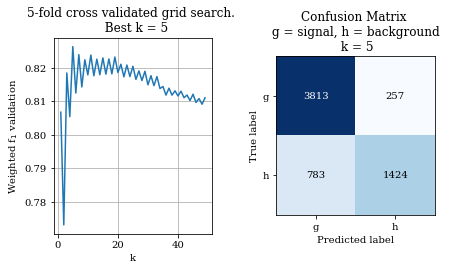

<IPython.core.display.Javascript object>

In [6]:
print("k-NN:")
print(f"Train weighted f1 score: {grid_search_knn.score(X_train, y_train):.2f}")
print(f"Test weighted f1 score: {grid_search_knn.score(X_test, y_test):.2f}")
print(f"Best k = {grid_search_knn.best_params_['n_neighbors']}")
fig, ax = plt.subplots(1, 2, figsize=[6.24123, 6.24123 / 1.618])
y_pred_test = encoder.inverse_transform(grid_search_knn.predict(X_test))
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    y_pred_test,
    ax=ax[1],
    hide_counts=False,
    normalize=False,
    title=f"Confusion Matrix "
    + f"\n g = signal, h = background "
    + f"\n k = {grid_search_knn.best_params_['n_neighbors']}",
)
# Scikit-plot doesn't let you disable colorbar, removing it manually
im = ax[1].images
cb = im[-1].colorbar
cb.remove()
ax[1].set_ylim([1.5, -0.5])
ax[1].set_xlim([-0.5, 1.5])
ax[0].plot(
    hyperparams_knn["n_neighbors"], grid_search_knn.cv_results_["mean_test_score"]
)
ax[0].set_xlabel("k")
ax[0].set_ylabel(r"Weighted f$_1$ validation")
ax[0].grid()
ax[0].set_title(
    f"5-fold cross validated grid search. \n  Best k = {grid_search_knn.best_params_['n_neighbors']}"
)
# fig.suptitle(fr"k Nearest Neighbors.")

fig.tight_layout()  # (rect=[0, 0.03, 1, 0.95])
fig.savefig("doc/figures/kNN_cv_results.pdf", dpi=1000)
plt.show()

# Tensorflow neural network

In [7]:
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

In [8]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(5, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train_split,
    y_train_split,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    verbose=0,
)

<IPython.core.display.Javascript object>

Neural Network:
Train weighted f1 score: 0.86
Test weighted f1 score: 0.87


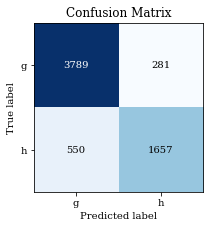

<IPython.core.display.Javascript object>

In [9]:
y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)

print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")


fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

# XGBoost

In [31]:
y_train_binary = (encoder.inverse_transform(y_train) == "g").astype(np.int).ravel()
xgboost = xgb.XGBClassifier(objective="binary:logistic", n_jobs=-1).fit(
    X=X_train, y=y_train_binary
)
xgboost.score(X_train, y_train_binary)

0.8818959428705956

<IPython.core.display.Javascript object>